In [1]:
__depends__ = [
    "../../../data/database-results/phase-1/timestamp.txt",
    "../../../data/database-observations/timestamp.txt",
]
__dest__ = []

In [2]:
%load_ext nb_black

<IPython.core.display.Javascript object>

#  ERF plots

Here we make plots of the different effective radiative forcings coming from the models. You must have run the `database-generation` notebook for this notebook to work.

## Imports

In [3]:
import glob
import logging
import os
import re
from pathlib import Path
from pprint import pprint
from distutils.util import strtobool

import pandas as pd
import pyam
import tqdm
from pymagicc.io import MAGICCData
from scmdata import df_append, ScmDataFrame

import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf

%matplotlib inline

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [4]:
TEST_RUN = strtobool(os.getenv("CI", "False")) or True
TEST_RUN

1

<IPython.core.display.Javascript object>

In [5]:
logger = logging.getLogger()

<IPython.core.display.Javascript object>

In [6]:
color_map_scenarios_base = {
    "ssp119": "AR6-SSP1-1.9",
    "ssp126": "AR6-SSP1-2.6",
    "ssp245": "AR6-SSP2-4.5",
    "ssp370": "AR6-SSP3-7.0",
    "ssp370-lowNTCF": "AR6-SSP3-LowNTCF",
    "ssp434": "AR6-SSP4-3.4",
    "ssp460": "AR6-SSP4-6.0",
    "ssp585": "AR6-SSP5-8.5",
    "ssp534-over": "AR6-SSP5-3.4-OS",
    "historical": "black",
    "rcp26": "AR5-RCP-2.6",
    "rcp45": "AR5-RCP-4.5",
    "rcp60": "AR5-RCP-6.0",
    "rcp85": "AR5-RCP-8.5",
    "historical-cmip5": "tab:gray",
}

color_map_scenarios = {}
for k, v in color_map_scenarios_base.items():
    color_map_scenarios[k] = v
    color_map_scenarios["esm-{}".format(k)] = v
    color_map_scenarios["esm-{}-allGHG".format(k)] = v

pyam.run_control().update({"color": {"scenario": color_map_scenarios}})

<IPython.core.display.Javascript object>

## Data

In [7]:
RESULTS_PATH = os.path.join("..", "..", "..", "data", "database-results", "phase-1")

<IPython.core.display.Javascript object>

In [8]:
results_files = list(Path(RESULTS_PATH).rglob("*.csv")) + list(
    Path(RESULTS_PATH).rglob("*.xlsx")
)
print(len(results_files))
sorted(results_files)[:10]

1375


[PosixPath('../../../data/database-results/phase-1/rcmip-phase-1_ar5ir2box-cmip6-bcc-csm2-mr-r1i1p1f1-calib_world_atmospheric-concentrations-co2.csv'),
 PosixPath('../../../data/database-results/phase-1/rcmip-phase-1_ar5ir2box-cmip6-bcc-csm2-mr-r1i1p1f1-calib_world_effective-radiative-forcing-anthropogenic-co2.csv'),
 PosixPath('../../../data/database-results/phase-1/rcmip-phase-1_ar5ir2box-cmip6-bcc-csm2-mr-r1i1p1f1-calib_world_effective-radiative-forcing.csv'),
 PosixPath('../../../data/database-results/phase-1/rcmip-phase-1_ar5ir2box-cmip6-bcc-csm2-mr-r1i1p1f1-calib_world_surface-air-temperature-change.csv'),
 PosixPath('../../../data/database-results/phase-1/rcmip-phase-1_ar5ir2box-cmip6-bcc-esm1-r1i1p1f1-calib_world_atmospheric-concentrations-co2.csv'),
 PosixPath('../../../data/database-results/phase-1/rcmip-phase-1_ar5ir2box-cmip6-bcc-esm1-r1i1p1f1-calib_world_effective-radiative-forcing-anthropogenic-co2.csv'),
 PosixPath('../../../data/database-results/phase-1/rcmip-phase-1_ar

<IPython.core.display.Javascript object>

In [9]:
model_of_interest = [
    #     ".*acc2.*",
    ".*cicero-scm.*",
    #     ".*escimo.*",
    ".*fair-1.5.*",
    #     ".*gir.*",
    #     ".*greb.*",
    #     ".*hector.*",
    #     ".*mce.*",
    ".*magicc7.*",
    #     ".*wasp.*",
]
if TEST_RUN:
    model_of_interest = [".*escimo.*", ".*greb.*", ".*cicero-scm.*"]

results_files = [
    str(p)
    for p in results_files
    if any([bool(re.match(m, str(p))) for m in model_of_interest]) and "$" not in str(p)
]
print(len(results_files))
results_files[:10]

349


['../../../data/database-results/phase-1/rcmip-phase-1_cicero-scm-ecs3_world_emissions-ch4.csv',
 '../../../data/database-results/phase-1/rcmip-phase-1_cicero-scm_world_radiative-forcing-anthropogenic-f-gases-hfc-hfc134a.csv',
 '../../../data/database-results/phase-1/rcmip-phase-1_cicero-scm-ecs3_world_atmospheric-concentrations-montreal-gases-cfc-cfc11.csv',
 '../../../data/database-results/phase-1/rcmip-phase-1_cicero-scm-ecs3_world_radiative-forcing-anthropogenic-co2.csv',
 '../../../data/database-results/phase-1/rcmip-phase-1_escimo,rcmip,base_world_effective-radiative-forcing.csv',
 '../../../data/database-results/phase-1/rcmip-phase-1_escimo,rcmip,base_world_heat-uptake.csv',
 '../../../data/database-results/phase-1/rcmip-phase-1_cicero-scm-ecs3_world_atmospheric-concentrations-f-gases-sf6.csv',
 '../../../data/database-results/phase-1/rcmip-phase-1_cicero-scm_world_effective-radiative-forcing-anthropogenic-f-gases-pfc-c2f6.csv',
 '../../../data/database-results/phase-1/rcmip-pha

<IPython.core.display.Javascript object>

## Miscellaneous functions

In [10]:
def convert_scmdf_to_pyamdf_year_only(iscmdf):
    out = iscmdf.timeseries()
    out.columns = out.columns.map(lambda x: x.year)

    return pyam.IamDataFrame(out)

<IPython.core.display.Javascript object>

In [11]:
def aggregate_variable(db_in, v_to_agg):
    if not db_in.filter(variable="*quantile*").timeseries().empty:
        raise NotImplementedError("quantile handling wrong")

    v_to_agg_df = (
        db_in.filter(variable=v_to_agg, keep=False)
        .filter(variable="{}|*".format(v_to_agg), level=0)
        .timeseries()
    )

    group_idx = list(set(v_to_agg_df.index.names) - {"variable"})
    v_to_agg_df = v_to_agg_df.groupby(group_idx).sum().reset_index()
    v_to_agg_df["variable"] = v_to_agg

    db_out = db_in.filter(variable=v_to_agg, keep=False).append(v_to_agg_df)

    return db_out

<IPython.core.display.Javascript object>

In [12]:
def subtract(base, other, axis, new_name):
    b_data = base.timeseries()
    o_data = other.timeseries()

    idx = b_data.index.names
    idx_tmp = list(set(idx) - {axis})

    b_data = b_data.reset_index().set_index(idx_tmp).drop(axis, axis="columns")
    o_data = o_data.reset_index().set_index(idx_tmp).drop(axis, axis="columns")

    res = (b_data - o_data).reset_index()
    res[axis] = new_name

    return pyam.IamDataFrame(res)

<IPython.core.display.Javascript object>

## AR6 FOD ERF estimates

These can be used for comparison with output data.

In [13]:
AR6_FOD_EFFRF_REGION = "World"
AR6_FOD_EFFRF_YEAR = 2017
AR6_FOD_EFFRF_ESTIMATES = {
    # FOD Table 7.4
    "Effective Radiative Forcing|Anthropogenic|CO2": 2.12,
    "Effective Radiative Forcing|Anthropogenic|CH4": 0.54,
    "Effective Radiative Forcing|Anthropogenic|N2O": 0.19,
    "Effective Radiative Forcing|Anthropogenic|Montreal Gases|CFC|CFC11": 0.059,
    "Effective Radiative Forcing|Anthropogenic|Montreal Gases|CFC|CFC12": 0.163,
    # # # MAGICC doesn't model CFC13 yet
    # "Effective Radiative Forcing|Anthropogenic|Montreal Gases|CFC|CFC13": 0.001,
    "Effective Radiative Forcing|Anthropogenic|Montreal Gases|CFC|CFC113": 0.021,
    "Effective Radiative Forcing|Anthropogenic|Montreal Gases|CFC|CFC115": 0.002,
    "Effective Radiative Forcing|Anthropogenic|Montreal Gases|HCFC22": 0.051,
    "Effective Radiative Forcing|Anthropogenic|Montreal Gases|HCFC141b": 0.004,
    "Effective Radiative Forcing|Anthropogenic|Montreal Gases|HCFC142b": 0.004,
    "Effective Radiative Forcing|Anthropogenic|F-Gases|HFC|HFC23": 0.005,
    "Effective Radiative Forcing|Anthropogenic|F-Gases|HFC|HFC32": 0.002,
    "Effective Radiative Forcing|Anthropogenic|F-Gases|HFC|HFC125": 0.005,
    "Effective Radiative Forcing|Anthropogenic|F-Gases|HFC|HFC134a": 0.015,
    "Effective Radiative Forcing|Anthropogenic|F-Gases|HFC|HFC143a": 0.003,
    "Effective Radiative Forcing|Anthropogenic|F-Gases|HFC|HFC152a": 0.001,
    "Effective Radiative Forcing|Anthropogenic|F-Gases|SF6": 0.005,
    "Effective Radiative Forcing|Anthropogenic|F-Gases|SO2F2": 0,
    "Effective Radiative Forcing|Anthropogenic|F-Gases|NF3": 0,
    "Effective Radiative Forcing|Anthropogenic|F-Gases|PFC|CF4": 0.004,
    "Effective Radiative Forcing|Anthropogenic|F-Gases|PFC|C2F6": 0.001,
    "Effective Radiative Forcing|Anthropogenic|Montreal Gases|CH3CCl3": 0,
    "Effective Radiative Forcing|Anthropogenic|Montreal Gases|CCl4": 0.014,
    # # TODO: work out which species are actually meant to go in these baskets
    "Effective Radiative Forcing|Anthropogenic|CFC": 0.254,
    "Effective Radiative Forcing|Anthropogenic|HCFC": 0.059,
    "Effective Radiative Forcing|Anthropogenic|F-Gases|HFC": 0.033,
    "Effective Radiative Forcing|Anthropogenic|Halogens": 0.374,
    # # TODO: work out which species are actually meant to go in this basket
    "Effective Radiative Forcing|Anthropogenic|Greenhouse Gases": 3.21,
    # FOD Table 7.7
    #     "Effective Radiative Forcing|Anthropogenic|Greenhouse Gases": 3.22,  # different to Table 7.4 for some reason...
    "Effective Radiative Forcing|Anthropogenic|Tropospheric Ozone": 0.37,
    "Effective Radiative Forcing|Anthropogenic|Stratospheric Ozone": -0.075,
    "Effective Radiative Forcing|Anthropogenic|Other|CH4 Oxidation Stratospheric H2O": 0.07,
    "Effective Radiative Forcing|Anthropogenic|Aerosols": -1.1,
    "Effective Radiative Forcing|Anthropogenic|Aerosols|Aerosols-radiation Interactions": -0.2,
    "Effective Radiative Forcing|Anthropogenic|Aerosols|Aerosols-cloud Interactions": -0.9,
    "Effective Radiative Forcing|Anthropogenic|Land-use Change": -0.15,
    "Effective Radiative Forcing|Anthropogenic|Other|BC on Snow": 0.08,
    "Effective Radiative Forcing|Anthropogenic|Aviation|Contrail and Cirrus": 0.05,
    "Effective Radiative Forcing|Anthropogenic|Anthropogenic": 2.48,
    "Effective Radiative Forcing|Natural|Solar": -0.01,
}

<IPython.core.display.Javascript object>

## Load data

In [14]:
def prep_str_for_filename(ins):
    return (
        ins.replace("_", "-")
        .replace("|", "-")
        .replace(" ", "-")
        .replace("(", "")
        .replace(")", "")
        .lower()
    )


variables_of_interest = [
    # you could make this list even more specific if needed
    "Effective Radiative Forcing*"
]
relevant_files = [
    str(p)
    for p in results_files
    if any(
        [
            bool(re.match(".*{}.*".format(prep_str_for_filename(v)), str(p)))
            for v in variables_of_interest
        ]
    )
]
print(len(relevant_files))
relevant_files[:20]

98


['../../../data/database-results/phase-1/rcmip-phase-1_escimo,rcmip,base_world_effective-radiative-forcing.csv',
 '../../../data/database-results/phase-1/rcmip-phase-1_cicero-scm_world_effective-radiative-forcing-anthropogenic-f-gases-pfc-c2f6.csv',
 '../../../data/database-results/phase-1/rcmip-phase-1_escimo,rcmip,base_world_effective-radiative-forcing-anthropogenic-aerosols.csv',
 '../../../data/database-results/phase-1/rcmip-phase-1_escimo,rcmip,base_world_effective-radiative-forcing-anthropogenic-co2.csv',
 '../../../data/database-results/phase-1/rcmip-phase-1_cicero-scm_world_effective-radiative-forcing-anthropogenic-albedo-change.csv',
 '../../../data/database-results/phase-1/rcmip-phase-1_cicero-scm-ecs3_world_effective-radiative-forcing-anthropogenic-aerosols-aerosols-cloud-interactions.csv',
 '../../../data/database-results/phase-1/rcmip-phase-1_cicero-scm_world_effective-radiative-forcing-anthropogenic-montreal-gases-cfc-cfc11.csv',
 '../../../data/database-results/phase-1/r

<IPython.core.display.Javascript object>

In [15]:
db = []
for rf in tqdm.tqdm_notebook(relevant_files):
    if rf.endswith(".csv"):
        loaded = ScmDataFrame(rf)
    else:
        loaded = ScmDataFrame(rf, sheet_name="your_data")
    db.append(loaded.filter(variable=variables_of_interest))

db = df_append(db).timeseries().reset_index()
db["unit"] = db["unit"].apply(
    lambda x: x.replace("Dimensionless", "dimensionless") if isinstance(x, str) else x
)
db = ScmDataFrame(db).filter(variable="*quantile*", keep=False)
db.head()

time                                                                                           1750-01-01 00:00:00  \
model       scenario       region variable                    unit  climatemodel unit_context                        
unspecified 1pctCO2        World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required                  0.0   
            1pctCO2-4xext  World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required                  0.0   
            abrupt-0p5xCO2 World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required                  0.0   
            abrupt-2xCO2   World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required                  0.0   
            abrupt-4xCO2   World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required                  0.0   

time                                                                                           1751-01-01 00:00:00  \
model       scenario       region variable                    unit  climatemodel unit_context                        
unspecified 1pctCO2        World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required                  0.0   
            1pctCO2-4xext  World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required                  0.0   
            abrupt-0p5xCO2 World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required                  0.0   
            abrupt-2xCO2   World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required                  0.0   
            abrupt-4xCO2   World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required                  0.0   

time                                                                                           1752-01-01 00:00:00  \
model       scenario       region variable                    unit  climatemodel unit_context                        
unspecified 1pctCO2        World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required                  0.0   
            1pctCO2-4xext  World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required                  0.0   
            abrupt-0p5xCO2 World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required                  0.0   
            abrupt-2xCO2   World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required                  0.0   
            abrupt-4xCO2   World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required                  0.0   

time                                                                                           1753-01-01 00:00:00  \
model       scenario       region variable                    unit  climatemodel unit_context                        
unspecified 1pctCO2        World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required            -0.000004   
            1pctCO2-4xext  World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required            -0.000004   
            abrupt-0p5xCO2 World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required            -0.000004   
            abrupt-2xCO2   World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required            -0.000004   
            abrupt-4xCO2   World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required            -0.000004   

time                                                                                           1754-01-01 00:00:00  \
model       scenario       region variable                    unit  climatemodel unit_context                        
unspecified 1pctCO2        World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required            -0.000004   
            1pctCO2-4xext  World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required            -0.000004   
            abrupt-0p5xCO2 World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required            -0.000004   
            abrupt-2xCO2   World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required         

<IPython.core.display.Javascript object>

In [16]:
db["scenario"].unique()

array(['1pctCO2', '1pctCO2-4xext', 'abrupt-0p5xCO2', 'abrupt-2xCO2',
       'abrupt-4xCO2', 'esm-hist', 'esm-hist-allGHG', 'esm-rcp26',
       'esm-rcp26-allGHG', 'esm-rcp45', 'esm-rcp45-allGHG', 'esm-rcp60',
       'esm-rcp60-allGHG', 'esm-rcp85', 'esm-rcp85-allGHG', 'esm-ssp119',
       'esm-ssp119-allGHG', 'esm-ssp126', 'esm-ssp126-allGHG',
       'esm-ssp245', 'esm-ssp245-allGHG', 'esm-ssp370',
       'esm-ssp370-allGHG', 'esm-ssp370-lowNTCF-aerchemmip',
       'esm-ssp370-lowNTCF-aerchemmip-allGHG',
       'esm-ssp370-lowNTCF-gidden', 'esm-ssp370-lowNTCF-gidden-allGHG',
       'esm-ssp434', 'esm-ssp434-allGHG', 'esm-ssp460',
       'esm-ssp460-allGHG', 'esm-ssp534-over', 'esm-ssp534-over-allGHG',
       'esm-ssp585', 'esm-ssp585-allGHG', 'historical', 'piControl',
       'rcp26', 'rcp45', 'rcp60', 'rcp85', 'ssp119', 'ssp126', 'ssp245',
       'ssp370', 'ssp370-lowNTCF-aerchemmip', 'ssp370-lowNTCF-gidden',
       'ssp434', 'ssp460', 'ssp534-over', 'ssp585', 'esm-piControl'],
      

<IPython.core.display.Javascript object>

In [17]:
db["climatemodel"].unique()

array(['Cicero-SCM', 'Cicero-SCM-ECS3', 'ESCIMO,rcmip,base'], dtype=object)

<IPython.core.display.Javascript object>

In [18]:
db["variable"].unique()

array(['Effective Radiative Forcing',
       'Effective Radiative Forcing|Anthropogenic',
       'Effective Radiative Forcing|Anthropogenic|Aerosols',
       'Effective Radiative Forcing|Anthropogenic|Aerosols|Aerosols-cloud Interactions',
       'Effective Radiative Forcing|Anthropogenic|Aerosols|Aerosols-radiation Interactions',
       'Effective Radiative Forcing|Anthropogenic|Aerosols|Aerosols-radiation Interactions|BC and OC|BC',
       'Effective Radiative Forcing|Anthropogenic|Aerosols|Aerosols-radiation Interactions|BC and OC|OC',
       'Effective Radiative Forcing|Anthropogenic|Aerosols|Aerosols-radiation Interactions|Biomass Burning',
       'Effective Radiative Forcing|Anthropogenic|Aerosols|Aerosols-radiation Interactions|Biomass Burning|BC and OC',
       'Effective Radiative Forcing|Anthropogenic|Aerosols|Aerosols-radiation Interactions|Biomass Burning|BC and OC|BC',
       'Effective Radiative Forcing|Anthropogenic|Aerosols|Aerosols-radiation Interactions|Biomass Burnin

<IPython.core.display.Javascript object>

## Aggregate some stuff

In [19]:
db = aggregate_variable(db, "Effective Radiative Forcing|Anthropogenic|F-Gases|HFC")
db = aggregate_variable(db, "Effective Radiative Forcing|Anthropogenic|Aerosols")
db.filter(variable="Effective Radiative Forcing|Anthropogenic|F-Gases|HFC").head()

Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!


time                                                                                                                  1750-01-01 00:00:00  \
model       scenario       region variable                                           unit  climatemodel unit_context                        
unspecified 1pctCO2        World  Effective Radiative Forcing|Anthropogenic|F-Gas... W/m^2 Cicero-SCM   not_required                  0.0   
            1pctCO2-4xext  World  Effective Radiative Forcing|Anthropogenic|F-Gas... W/m^2 Cicero-SCM   not_required                  0.0   
            abrupt-0p5xCO2 World  Effective Radiative Forcing|Anthropogenic|F-Gas... W/m^2 Cicero-SCM   not_required                  0.0   
            abrupt-2xCO2   World  Effective Radiative Forcing|Anthropogenic|F-Gas... W/m^2 Cicero-SCM   not_required                  0.0   
            abrupt-4xCO2   World  Effective Radiative Forcing|Anthropogenic|F-Gas... W/m^2 Cicero-SCM   not_required                  0.0   

time                                                                                                                  1751-01-01 00:00:00  \
model       scenario       region variable                                           unit  climatemodel unit_context                        
unspecified 1pctCO2        World  Effective Radiative Forcing|Anthropogenic|F-Gas... W/m^2 Cicero-SCM   not_required                  0.0   
            1pctCO2-4xext  World  Effective Radiative Forcing|Anthropogenic|F-Gas... W/m^2 Cicero-SCM   not_required                  0.0   
            abrupt-0p5xCO2 World  Effective Radiative Forcing|Anthropogenic|F-Gas... W/m^2 Cicero-SCM   not_required                  0.0   
            abrupt-2xCO2   World  Effective Radiative Forcing|Anthropogenic|F-Gas... W/m^2 Cicero-SCM   not_required                  0.0   
            abrupt-4xCO2   World  Effective Radiative Forcing|Anthropogenic|F-Gas... W/m^2 Cicero-SCM   not_required                  0.0   

time                                                                                                                  1752-01-01 00:00:00  \
model       scenario       region variable                                           unit  climatemodel unit_context                        
unspecified 1pctCO2        World  Effective Radiative Forcing|Anthropogenic|F-Gas... W/m^2 Cicero-SCM   not_required                  0.0   
            1pctCO2-4xext  World  Effective Radiative Forcing|Anthropogenic|F-Gas... W/m^2 Cicero-SCM   not_required                  0.0   
            abrupt-0p5xCO2 World  Effective Radiative Forcing|Anthropogenic|F-Gas... W/m^2 Cicero-SCM   not_required                  0.0   
            abrupt-2xCO2   World  Effective Radiative Forcing|Anthropogenic|F-Gas... W/m^2 Cicero-SCM   not_required                  0.0   
            abrupt-4xCO2   World  Effective Radiative Forcing|Anthropogenic|F-Gas... W/m^2 Cicero-SCM   not_required                  0.0   

time                                                                                                                  1753-01-01 00:00:00  \
model       scenario       region variable                                           unit  climatemodel unit_context                        
unspecified 1pctCO2        World  Effective Radiative Forcing|Anthropogenic|F-Gas... W/m^2 Cicero-SCM   not_required                  0.0   
            1pctCO2-4xext  World  Effective Radiative Forcing|Anthropogenic|F-Gas... W/m^2 Cicero-SCM   not_required                  0.0   
            abrupt-0p5xCO2 World  Effective Radiative Forcing|Anthropogenic|F-Gas... W/m^2 Cicero-SCM   not_required                  0.0   
            abrupt-2xCO2   World  Effective Radiative Forcing|Anthropogenic|F-Gas... W/m^2 Cicero-SCM   not_required                  0.0   
            abrupt-4xCO2   World  Effective Radiative Forcing|Anthropogenic|F-Gas... W/m^2 Cicero-SCM   not_required                  0.0   

time                                            

<IPython.core.display.Javascript object>

In [20]:
db.filter(variable="Effective Radiative Forcing|Anthropogenic|Aerosols").head()

time                                                                                                                  1750-01-01 00:00:00  \
model       scenario       region variable                                           unit  climatemodel unit_context                        
unspecified 1pctCO2        World  Effective Radiative Forcing|Anthropogenic|Aerosols W/m^2 Cicero-SCM   not_required                  0.0   
            1pctCO2-4xext  World  Effective Radiative Forcing|Anthropogenic|Aerosols W/m^2 Cicero-SCM   not_required                  0.0   
            abrupt-0p5xCO2 World  Effective Radiative Forcing|Anthropogenic|Aerosols W/m^2 Cicero-SCM   not_required                  0.0   
            abrupt-2xCO2   World  Effective Radiative Forcing|Anthropogenic|Aerosols W/m^2 Cicero-SCM   not_required                  0.0   
            abrupt-4xCO2   World  Effective Radiative Forcing|Anthropogenic|Aerosols W/m^2 Cicero-SCM   not_required                  0.0   

time                                                                                                                  1751-01-01 00:00:00  \
model       scenario       region variable                                           unit  climatemodel unit_context                        
unspecified 1pctCO2        World  Effective Radiative Forcing|Anthropogenic|Aerosols W/m^2 Cicero-SCM   not_required                  0.0   
            1pctCO2-4xext  World  Effective Radiative Forcing|Anthropogenic|Aerosols W/m^2 Cicero-SCM   not_required                  0.0   
            abrupt-0p5xCO2 World  Effective Radiative Forcing|Anthropogenic|Aerosols W/m^2 Cicero-SCM   not_required                  0.0   
            abrupt-2xCO2   World  Effective Radiative Forcing|Anthropogenic|Aerosols W/m^2 Cicero-SCM   not_required                  0.0   
            abrupt-4xCO2   World  Effective Radiative Forcing|Anthropogenic|Aerosols W/m^2 Cicero-SCM   not_required                  0.0   

time                                                                                                                  1752-01-01 00:00:00  \
model       scenario       region variable                                           unit  climatemodel unit_context                        
unspecified 1pctCO2        World  Effective Radiative Forcing|Anthropogenic|Aerosols W/m^2 Cicero-SCM   not_required                  0.0   
            1pctCO2-4xext  World  Effective Radiative Forcing|Anthropogenic|Aerosols W/m^2 Cicero-SCM   not_required                  0.0   
            abrupt-0p5xCO2 World  Effective Radiative Forcing|Anthropogenic|Aerosols W/m^2 Cicero-SCM   not_required                  0.0   
            abrupt-2xCO2   World  Effective Radiative Forcing|Anthropogenic|Aerosols W/m^2 Cicero-SCM   not_required                  0.0   
            abrupt-4xCO2   World  Effective Radiative Forcing|Anthropogenic|Aerosols W/m^2 Cicero-SCM   not_required                  0.0   

time                                                                                                                  1753-01-01 00:00:00  \
model       scenario       region variable                                           unit  climatemodel unit_context                        
unspecified 1pctCO2        World  Effective Radiative Forcing|Anthropogenic|Aerosols W/m^2 Cicero-SCM   not_required                  0.0   
            1pctCO2-4xext  World  Effective Radiative Forcing|Anthropogenic|Aerosols W/m^2 Cicero-SCM   not_required                  0.0   
            abrupt-0p5xCO2 World  Effective Radiative Forcing|Anthropogenic|Aerosols W/m^2 Cicero-SCM   not_required                  0.0   
            abrupt-2xCO2   World  Effective Radiative Forcing|Anthropogenic|Aerosols W/m^2 Cicero-SCM   not_required                  0.0   
            abrupt-4xCO2   World  Effective Radiative Forcing|Anthropogenic|Aerosols W/m^2 Cicero-SCM   not_required                  0.0   

time                                            

<IPython.core.display.Javascript object>

## ERFs

Here we plot the effective radiative forcing for a number of different species and compare to the AR6 FOD estimates.

In [21]:
db["climatemodel"].unique()

array(['Cicero-SCM', 'Cicero-SCM-ECS3', 'ESCIMO,rcmip,base'], dtype=object)

<IPython.core.display.Javascript object>

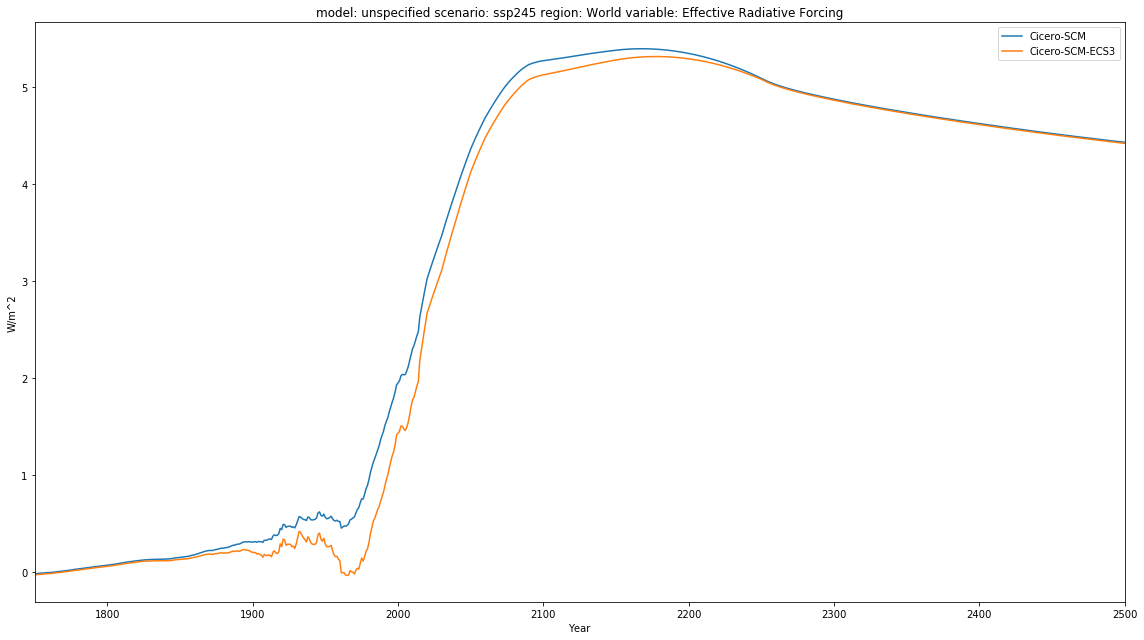

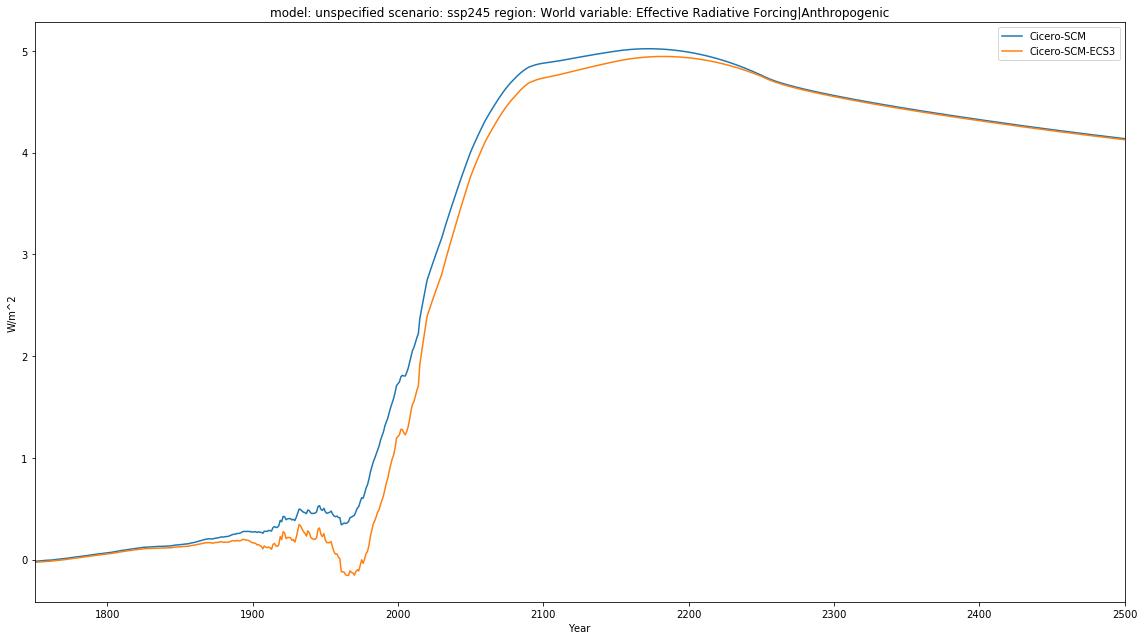

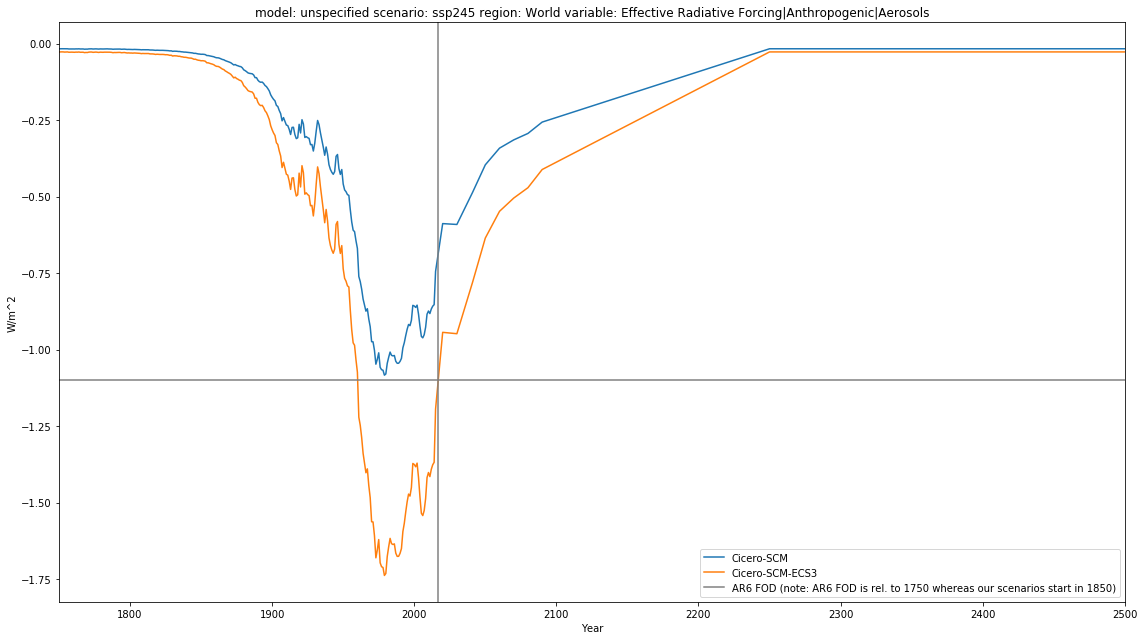

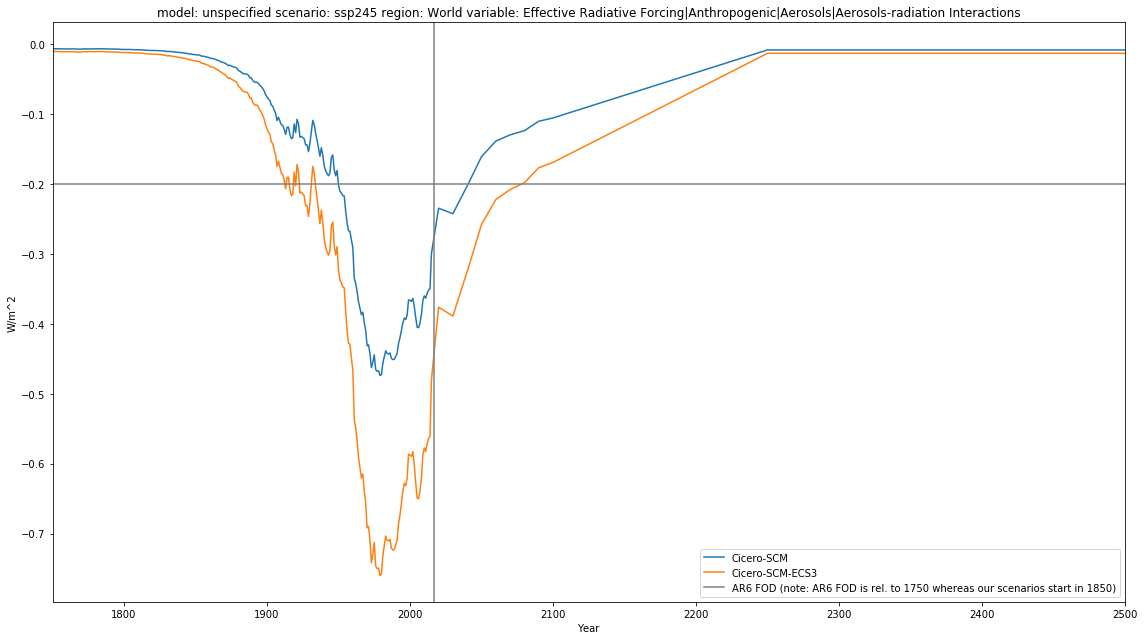

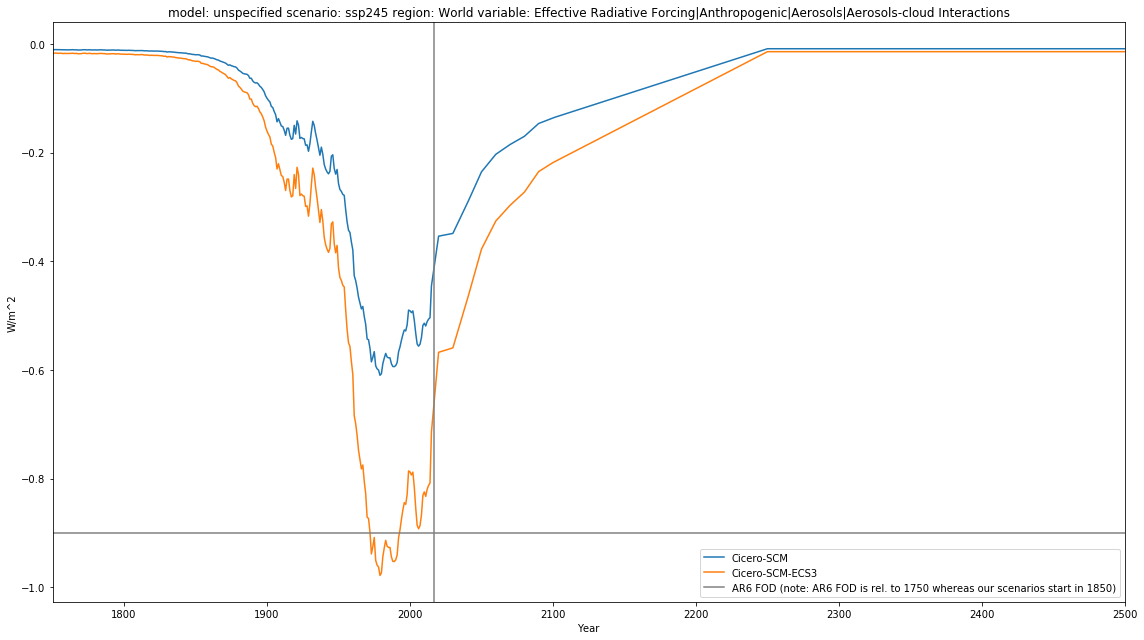

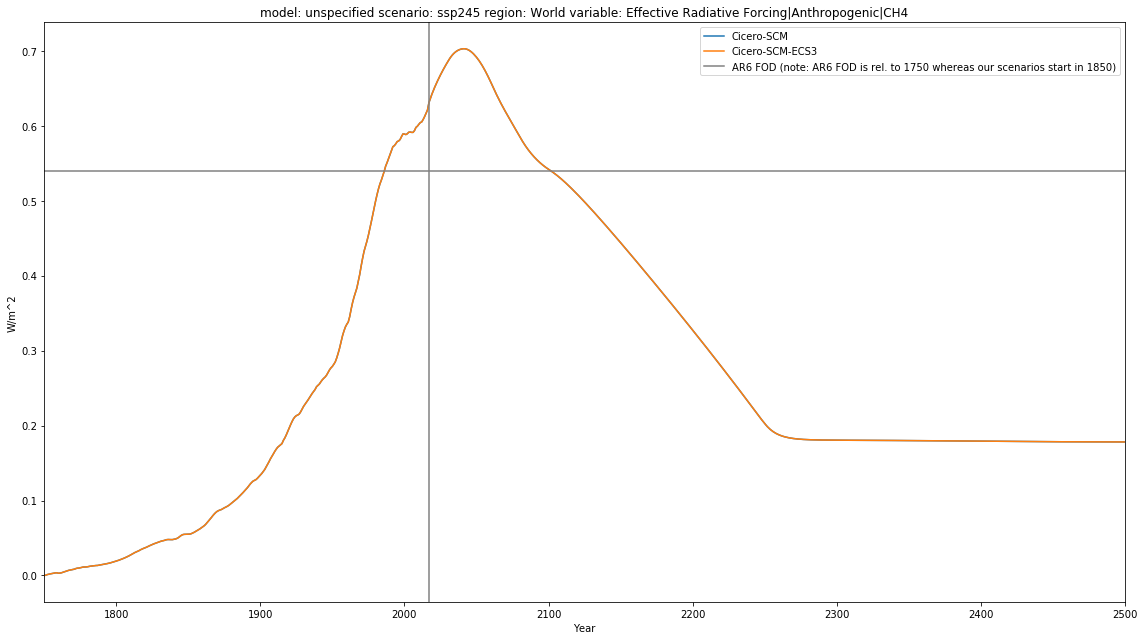

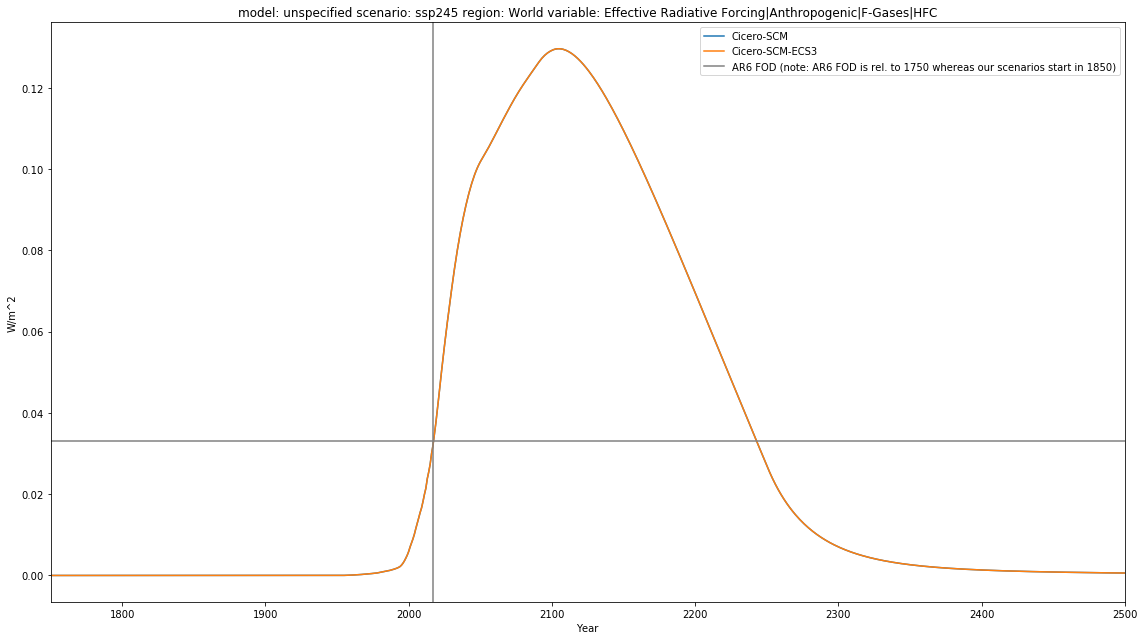

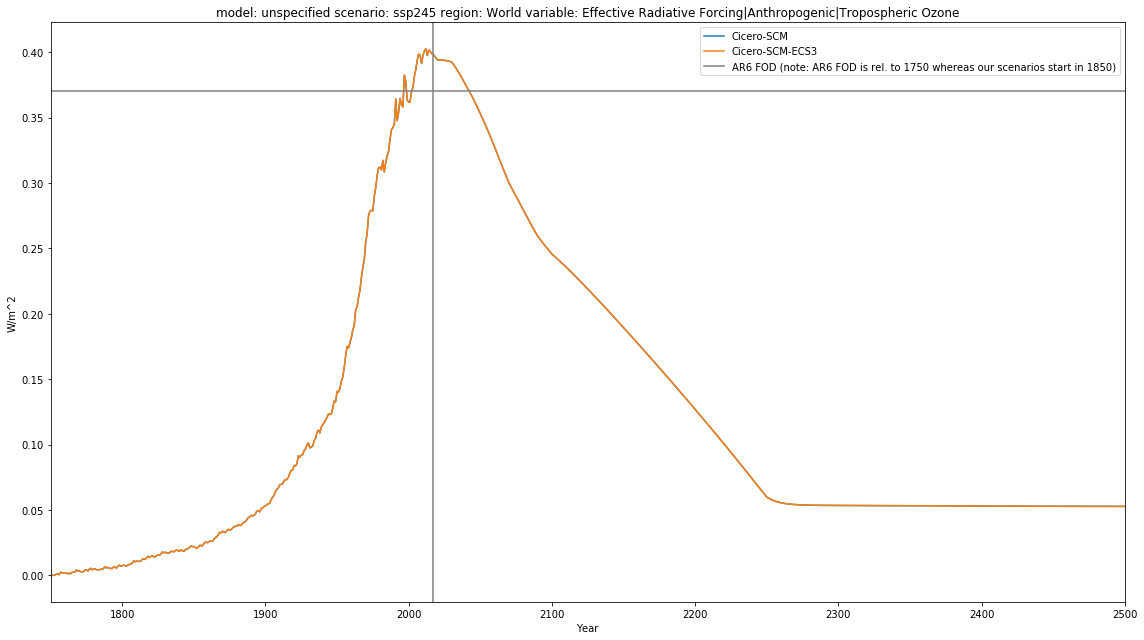

<IPython.core.display.Javascript object>

In [22]:
interesting_models = ["MAGICC*", "*Cicero*", "*FaIR*"]  # rest are CO2 only
filters_variables = [
    ["Effective Radiative Forcing", "Effective Radiative Forcing|50*"],
    [
        "Effective Radiative Forcing|Anthropogenic",
        "Effective Radiative Forcing|Anthropogenic|50*",
    ],
    #     [
    #         "Effective Radiative Forcing|Anthropogenic|CO2",
    #         "Effective Radiative Forcing|Anthropogenic|CO2|50*",
    #     ],
    [
        "Effective Radiative Forcing|Anthropogenic|Aerosols",
        "Effective Radiative Forcing|Anthropogenic|Aerosols|50*",
    ],
    [
        "Effective Radiative Forcing|Anthropogenic|Aerosols|Aerosols-radiation Interactions",
        "Effective Radiative Forcing|Anthropogenic|Aerosols|Aerosols-radiation Interactions|50*",
    ],
    [
        "Effective Radiative Forcing|Anthropogenic|Aerosols|Aerosols-cloud Interactions",
        "Effective Radiative Forcing|Anthropogenic|Aerosols|Aerosols-cloud Interactions|50*",
    ],
    [
        "Effective Radiative Forcing|Anthropogenic|CH4",
        "Effective Radiative Forcing|Anthropogenic|CH4|50*",
    ],
    [
        "Effective Radiative Forcing|Anthropogenic|F-Gases|HFC",
        "Effective Radiative Forcing|Anthropogenic|F-Gases|HFC|50*",
    ],
    [
        "Effective Radiative Forcing|Anthropogenic|Tropospheric Ozone",
        "Effective Radiative Forcing|Anthropogenic|Tropospheric Ozone|50*",
    ],
    #     [
    #         "Effective Radiative Forcing|Anthropogenic|Other|BC on Snow",
    #         "Effective Radiative Forcing|Anthropogenic|Other|BC on Snow|50*",
    #     ],
    [
        "Effective Radiative Forcing|Anthropogenic|Stratospheric Ozone",
        "Effective Radiative Forcing|Anthropogenic|Stratospheric Ozone|50*",
    ],
]
scenarios = ["ssp245"]
region = "World"

pdf_to_save = matplotlib.backends.backend_pdf.PdfPages("slcf-erfs.pdf")

for filter_var in tqdm.tqdm_notebook(filters_variables, desc="Variable"):
    fig = plt.figure(figsize=(16, 9))
    ax = fig.add_subplot(111)
    pdf = db.filter(
        variable=filter_var,
        region=region,
        scenario=scenarios,
        climatemodel=interesting_models,
    )

    pdf = pdf.timeseries()
    pdf.columns = pdf.columns.map(lambda x: x.year)
    ax = pyam.IamDataFrame(pdf).line_plot(
        color="climatemodel",
        ax=ax,
        legend=True
        #         color="scenario", linestyle="climatemodel", ax=ax, legend=True
    )

    if filter_var[0] in AR6_FOD_EFFRF_ESTIMATES:
        ax.axhline(
            AR6_FOD_EFFRF_ESTIMATES[filter_var[0]],
            color="grey",
            label="AR6 FOD (note: AR6 FOD is rel. to 1750 whereas our scenarios start in 1850)",
        )
        ax.axvline(2017, color="grey", label=None)
        ax.legend()

    plt.tight_layout()
    pdf_to_save.savefig(fig)

pdf_to_save.close()